# Visualise *hrp2* and *hrp3* Deletions

## Introduction

This notebook will create a public notebook for the generation of Figure 5 from the main [Pf7 paper](https://wellcomeopenresearch.org/articles/8-22) - a figure of HRP deletion breakpoints.

*hrp2* and *hrp3* are genes located in subtelomeric regions of the genome with very high levels of natural variation. Deletion in those genes can cause failure of rapid diagnostic tests and is therefore important to monitor.

Deletion is a genetic event in which a segment of DNA is entirely removed or missing. In this context, 'breakpoints' denote specific locations on the chromosome where such deletions take place.

**This notebook should take approximately two minutes to run.**

## Setup

Install and import the malariagen Python package:

In [1]:
!pip install -q --no-warn-conflicts malariagen_data
import malariagen_data

Import required python libraries that are installed at colab by default.

In [2]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from google.colab import drive

## Access Pf7 Data

We use the malariagen data package to load the release data.

In [3]:
release_data = malariagen_data.Pf7()
df_samples = release_data.sample_metadata()

## *hrp2* & *hrp3* Deletions

We additionally require list of deletion and breakpoint locations within the histidine-rich protein genes II and III (HRP-2 and -3) across 16,203 QC-pass samples. We can access this data from [MalariaGEN web page](http://malariagen.net/resource/34).

In [4]:
# Fetch details of hrp calls from this MalariaGEN.net file
hrp_calls_fn = pd.read_csv('https://www.malariagen.net/wp-content/uploads/2024/01/hrp_calls_pf7.tsv', sep='\t')

# Print the shape and first rows
print(hrp_calls_fn.shape)
hrp_calls_fn.head()

(16203, 7)


Sample        HRP2        HRP3 HRP2_breakpoint HRP3_breakpoint  \
0   FP0008-C       nodel       nodel               -               -   
1   FP0009-C       nodel       nodel               -               -   
2  FP0010-CW  uncallable  uncallable               -               -   
3  FP0011-CW  uncallable  uncallable               -               -   
4  FP0012-CW       nodel       nodel               -               -   

  HRP2_deletion_type HRP3_deletion_type  
0                NaN                NaN  
1                NaN                NaN  
2                NaN                NaN  
3                NaN                NaN  
4                NaN                NaN

Now, let's merge `hrp_calls_fn` with `df_samples` which contains various metadata of Pf7 samples.

In [5]:
# Merge df_samples with hrp_calls_fn
df_samples =  df_samples.merge(hrp_calls_fn, on ='Sample')

## 3D7 Reference Annotation

Another relevant dataset in this notebook is the 3D7 reference annotation which is
used for genome annotations in Pf7. It can be accessed at the following FTP link: ftp://ngs.sanger.ac.uk/production/malaria/Resource/34/Pfalciparum_replace_Pf3D7_MIT_v3_with_Pf_M76611.gff.


We will use the `wget` package to download this file. After running the following cell, the file should appear in the list of files on the left.

In [6]:
!wget ftp://ngs.sanger.ac.uk/production/malaria/Resource/34/Pfalciparum_replace_Pf3D7_MIT_v3_with_Pf_M76611.gff

--2024-02-08 11:27:43--  ftp://ngs.sanger.ac.uk/production/malaria/Resource/34/Pfalciparum_replace_Pf3D7_MIT_v3_with_Pf_M76611.gff
           => ‘Pfalciparum_replace_Pf3D7_MIT_v3_with_Pf_M76611.gff.1’
Resolving ngs.sanger.ac.uk (ngs.sanger.ac.uk)... 193.62.203.221
Connecting to ngs.sanger.ac.uk (ngs.sanger.ac.uk)|193.62.203.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /production/malaria/Resource/34 ... done.
==> SIZE Pfalciparum_replace_Pf3D7_MIT_v3_with_Pf_M76611.gff ... 21035550
==> PASV ... done.    ==> RETR Pfalciparum_replace_Pf3D7_MIT_v3_with_Pf_M76611.gff ... done.
Length: 21035550 (20M) (unauthoritative)

Pfalciparum_replace 100%[===================>]  20.06M  18.2MB/s    in 1.1s    

2024-02-08 11:27:45 (18.2 MB/s) - ‘Pfalciparum_replace_Pf3D7_MIT_v3_with_Pf_M76611.gff.1’ saved [21035550]



This file is in GFF file format defined by [Ensembl](https://www.ensembl.org/info/website/upload/gff.html).

Since the file is tab-separated, we can proceed to read the data into a Pandas dataframe once again.

In [7]:
# Read the file column names.
df_gff = pd.read_csv('/content/Pfalciparum_replace_Pf3D7_MIT_v3_with_Pf_M76611.gff', names=['chrom', 'db', 'type', 'start', 'end', 'u1', 'strand', 'u2', 'id'], comment='#', sep='\t')
# Print the shape (rows and columns) of df_gff
print(df_gff.shape)
# Show the first 5 rows
df_gff.head()

(40713, 9)


chrom     db           type  start   end u1 strand u2  \
0  Pf3D7_01_v3  chado  repeat_region      1   360  .      +  .   
1  Pf3D7_01_v3  chado  repeat_region    361  1418  .      +  .   
2  Pf3D7_01_v3  chado  repeat_region   2160  3858  .      +  .   
3  Pf3D7_01_v3  chado  repeat_region   8856  9021  .      +  .   
4  Pf3D7_01_v3  chado  repeat_region   9313  9529  .      +  .   

                                                  id  
0  ID=Pfalciparum_REP_20;comment=telomeric repeat...  
1          ID=Pfalciparum_REP_15;comment=14bp repeat  
2          ID=Pfalciparum_REP_35;comment=65bp repeat  
3           ID=Pfalciparum_REP_5;comment=25bp repeat  
4          ID=Pfalciparum_REP_25;comment=26bp repeat

## Figure Preparation

We need to find the start and end positions of chromosomes to draw gene annotations in the figure that we are going to create.

In [8]:
# Find start and end positions for each chromosome by grouping chromosome coordinates
df_chroms = df_gff.groupby('chrom').agg({'start': 'min', 'end': 'max'}).reset_index()
# Set 'chrom' as the index
df_chroms.set_index('chrom', inplace=True)
df_chroms

start      end
chrom                       
Pf3D7_01_v3       1   640851
Pf3D7_02_v3       1   947102
Pf3D7_03_v3       1  1067971
Pf3D7_04_v3       1  1200490
Pf3D7_05_v3       1  1343557
Pf3D7_06_v3       1  1418242
Pf3D7_07_v3       1  1445207
Pf3D7_08_v3       1  1472805
Pf3D7_09_v3       1  1541735
Pf3D7_10_v3       1  1687656
Pf3D7_11_v3       1  2038340
Pf3D7_12_v3       1  2260569
Pf3D7_13_v3       1  2925236
Pf3D7_14_v3       1  3291936
Pf3D7_API_v3      1    34225
Pf_M76611         3     5954

The next question is: How many samples have deletions in each country?

In [9]:
# This function returns samples with deletion for each country.

def breakpoint_agg(x):
    names = collections.OrderedDict()
    names['Countries'] = ''
    countries = []
    # Loop over each country
    # Count non-zero samples (with deletion)
    for country in x['Country'].unique():
        countries.append(f"{country} ({np.count_nonzero(x['Country'] == country)})")
    # Join together country name and number
    names['Countries'] = ', '.join(countries)
    names['Samples with deletion'] = len(x)
    return pd.Series(names)

We will apply `breakpoint_agg` function to `df_samples` separately for *hrp2* and *hrp3*.

Additionally, we will find genomic coordinates at the edges for mapping in the figure.

In [10]:
# Group samples by Deletion type and HRP3_breakpoint
# Apply breakpoint_agg to count samples with deletion in each country
df_hrp2 = (
    df_samples[
        df_samples['QC pass']
        & ( df_samples['HRP2'] == 'del' )
]
    .assign(Gene='$hrp2$')
    .rename(columns={'HRP2_deletion_type': 'Deletion type'})
    .groupby(['Deletion type', 'HRP2_breakpoint'])
    .apply(breakpoint_agg)
    .reset_index()
)
# Seperate coordinate value from chromosome
df_hrp2['breakpoint'] = df_hrp2['HRP2_breakpoint'].apply(lambda x: int(x.split(':')[1]))

# Print min and max coordinates
print(f"HRP2 min breakpoint = {df_hrp2['breakpoint'].min()}")
print(f"HRP2 max breakpoint = {df_hrp2['breakpoint'].max()}")
df_hrp2

HRP2 min breakpoint = 1373732
HRP2 max breakpoint = 1374986


Deletion type      HRP2_breakpoint      Countries  \
0  Telomere healing  Pf3D7_08_v3:1373732   Cambodia (1)   
1  Telomere healing  Pf3D7_08_v3:1374280      Sudan (1)   
2  Telomere healing  Pf3D7_08_v3:1374462  Indonesia (5)   
3  Telomere healing  Pf3D7_08_v3:1374932       Peru (2)   
4  Telomere healing  Pf3D7_08_v3:1374986       Peru (6)   

   Samples with deletion  breakpoint  
0                      1     1373732  
1                      1     1374280  
2                      5     1374462  
3                      2     1374932  
4                      6     1374986

A repeat of the same look-up for *hrp3*.

In [11]:
# Group samples by Deletion type and HRP3_breakpoint
# Apply breakpoint_agg to count samples with deletion in each country
df_hrp3 = (
    df_samples[
        df_samples['QC pass']
        & ( df_samples['HRP3'] == 'del' )
    ]
    .rename(columns={'HRP3_deletion_type': 'Deletion type'})
    .groupby(['Deletion type', 'HRP3_breakpoint'])
    .apply(breakpoint_agg)
    .reset_index()
)
# Seperate coordinate value from chromosome
df_hrp3['breakpoint'] = df_hrp3['HRP3_breakpoint'].apply(lambda x: x.split(':')[1])

# Print min and max coordinates
print(f"HRP3 min breakpoint = {df_hrp3['breakpoint'].min()}")
print(f"HRP3 max breakpoint = {df_hrp3['breakpoint'].max()}")
df_hrp3

HRP3 min breakpoint = 2800004-2807159
HRP3 max breakpoint = 2841120


Deletion type              HRP3_breakpoint  \
0   Chromosome 11 recombination  Pf3D7_13_v3:2800004-2807159   
1    Chromosome 5 recombination  Pf3D7_13_v3:2835587-2835612   
2              Telomere healing          Pf3D7_13_v3:2811525   
3              Telomere healing          Pf3D7_13_v3:2812344   
4              Telomere healing          Pf3D7_13_v3:2815249   
5              Telomere healing          Pf3D7_13_v3:2822480   
6              Telomere healing          Pf3D7_13_v3:2823645   
7              Telomere healing          Pf3D7_13_v3:2830952   
8              Telomere healing          Pf3D7_13_v3:2832080   
9              Telomere healing          Pf3D7_13_v3:2834604   
10             Telomere healing          Pf3D7_13_v3:2835532   
11             Telomere healing          Pf3D7_13_v3:2837145   
12             Telomere healing          Pf3D7_13_v3:2837392   
13             Telomere healing          Pf3D7_13_v3:2838654   
14             Telomere healing          Pf3D7_13_v3:2841024   
15             Telomere healing          Pf3D7_13_v3:2841120   

                                            Countries  Samples with deletion  \
0   Thailand (1), Ghana (1), Indonesia (40), Peru ...                    151   
1                          Cambodia (20), Vietnam (1)                     21   
2                                           India (1)                      1   
3                                           Sudan (1)                      1   
4                                        Tanzania (1)                      1   
5                                           Ghana (1)                      1   
6                                           Kenya (1)                      1   
7                                        Cambodia (7)                      7   
8                Democratic Republic of the Congo (1)                      1   
9                                         Vietnam (1)                      1   
10                                       Thailand (1)                      1   
11                                        Vietnam (7)                      7   
12                             Cambodia (2), Laos (1)                      3   
13                                      Indonesia (2)                      2   
14                                       Thailand (1)                      1   
15                                      Indonesia (1)                      1   

         breakpoint  
0   2800004-2807159  
1   2835587-2835612  
2           2811525  
3           2812344  
4           2815249  
5           2822480  
6           2823645  
7           2830952  
8           2832080  
9           2834604  
10          2835532  
11          2837145  
12          2837392  
13          2838654  
14          2841024  
15          2841120

It seems that Chromosome 11 recombination breakpoints are observed in multiple countries which motivates us to print the full list of countries.

In [12]:
# Locate the first row by using the index
df_hrp3.iloc[0]['Countries']

'Thailand (1), Ghana (1), Indonesia (40), Peru (15), Bangladesh (1), Vietnam (2), Colombia (50), Ethiopia (9), Senegal (6), Laos (14), Cambodia (3), Sudan (5), Mali (1), Gambia (3)'

Given the fact that many of these events result in the deletion of other genes in addition to *hrp2* and *hrp3*.

We could have a look at which genes are present within the range of breakpoints before including them in the plot.

In [13]:
# Genes in hrp2 breakpoints
df_gff.loc[
    ( df_gff['chrom'] == 'Pf3D7_08_v3' )
    & ( df_gff['start'] <= 1375500 )
    & ( df_gff['end'] >= 1364000 )
]

chrom     db                    type    start      end u1 strand  \
15534  Pf3D7_08_v3  chado         three_prime_UTR  1364640  1365466  .      -   
15535  Pf3D7_08_v3  chado                    gene  1364640  1369862  .      -   
15536  Pf3D7_08_v3  chado                    mRNA  1364640  1369862  .      -   
15537  Pf3D7_08_v3  chado                     CDS  1365467  1367506  .      -   
15538  Pf3D7_08_v3  chado             polypeptide  1365467  1367506  .      -   
15539  Pf3D7_08_v3  chado          five_prime_UTR  1367507  1367640  .      -   
15540  Pf3D7_08_v3  chado          five_prime_UTR  1368649  1369862  .      -   
15541  Pf3D7_08_v3  chado        pseudogenic_exon  1371847  1372100  .      +   
15542  Pf3D7_08_v3  chado              pseudogene  1371847  1372720  .      +   
15543  Pf3D7_08_v3  chado  pseudogenic_transcript  1371847  1372720  .      +   
15544  Pf3D7_08_v3  chado             polypeptide  1371847  1372720  .      +   
15545  Pf3D7_08_v3  chado        pseudogenic_exon  1372103  1372223  .      +   
15546  Pf3D7_08_v3  chado        pseudogenic_exon  1372225  1372291  .      +   
15547  Pf3D7_08_v3  chado        pseudogenic_exon  1372294  1372577  .      +   
15548  Pf3D7_08_v3  chado        pseudogenic_exon  1372579  1372667  .      +   
15549  Pf3D7_08_v3  chado        pseudogenic_exon  1372669  1372720  .      +   
15550  Pf3D7_08_v3  chado         three_prime_UTR  1373212  1374235  .      -   
15551  Pf3D7_08_v3  chado                    gene  1373212  1376988  .      -   
15552  Pf3D7_08_v3  chado                    mRNA  1373212  1376988  .      -   
15553  Pf3D7_08_v3  chado                     CDS  1374236  1375084  .      -   
15554  Pf3D7_08_v3  chado             polypeptide  1374236  1375299  .      -   
15555  Pf3D7_08_v3  chado                     CDS  1375231  1375299  .      -   
15556  Pf3D7_08_v3  chado          five_prime_UTR  1375300  1376988  .      -   

      u2                                                 id  
15534  .     ID=PF3D7_0831700.1:3UTR;Parent=PF3D7_0831700.1  
15535  .  ID=PF3D7_0831700;Name=HSP70x;previous_systemat...  
15536  .  ID=PF3D7_0831700.1;comment=HSP70-x can be knoc...  
15537  0   ID=PF3D7_0831700.1:exon:1;Parent=PF3D7_0831700.1  
15538  .  ID=PF3D7_0831700.1:pep;Derives_from=PF3D7_0831...  
15539  .   ID=PF3D7_0831700.1:5UTR:1;Parent=PF3D7_0831700.1  
15540  .     ID=PF3D7_0831700.1:5UTR;Parent=PF3D7_0831700.1  
15541  .   ID=PF3D7_0831750.1:exon:2;Parent=PF3D7_0831750.1  
15542  .                                   ID=PF3D7_0831750  
15543  .  ID=PF3D7_0831750.1;Parent=PF3D7_0831750;Dbxref...  
15544  .  ID=PF3D7_0831750.1:pep;Derives_from=PF3D7_0831...  
15545  .   ID=PF3D7_0831750.1:exon:3;Parent=PF3D7_0831750.1  
15546  .   ID=PF3D7_0831750.1:exon:4;Parent=PF3D7_0831750.1  
15547  .   ID=PF3D7_0831750.1:exon:5;Parent=PF3D7_0831750.1  
15548  .   ID=PF3D7_0831750.1:exon:6;Parent=PF3D7_0831750.1  
15549  .   ID=PF3D7_0831750.1:exon:7;Parent=PF3D7_0831750.1  
15550  .     ID=PF3D7_0831800.1:3UTR;Parent=PF3D7_0831800.1  
15551  .  ID=PF3D7_0831800;Name=HRP2;previous_systematic...  
15552  .  ID=PF3D7_0831800.1;comment=HRP2%2C which is on...  
15553  0   ID=PF3D7_0831800.1:exon:3;Parent=PF3D7_0831800.1  
15554  .  ID=PF3D7_0831800.1:pep;Derives_from=PF3D7_0831...  
15555  0   ID=PF3D7_0831800.1:exon:2;Parent=PF3D7_0831800.1  
15556  .     ID=PF3D7_0831800.1:5UTR;Parent=PF3D7_0831800.1

In [14]:
# Genes in hrp3 breakpoints
pd.options.display.max_rows = 100
df_gff.loc[
    ( df_gff['chrom'] == 'Pf3D7_13_v3' )
    & ( df_gff['start'] <= 2845000 )
    & ( df_gff['end'] >= 2795000 )
]

chrom     db                    type    start      end u1 strand  \
34303  Pf3D7_13_v3  chado                    gene  2796119  2797144  .      +   
34304  Pf3D7_13_v3  chado                   ncRNA  2796119  2797144  .      +   
34305  Pf3D7_13_v3  chado                     CDS  2796119  2797144  .      +   
34306  Pf3D7_13_v3  chado                    gene  2797507  2798103  .      +   
34307  Pf3D7_13_v3  chado                   ncRNA  2797507  2798103  .      +   
34308  Pf3D7_13_v3  chado                     CDS  2797507  2798103  .      +   
34309  Pf3D7_13_v3  chado                    gene  2800004  2802154  .      +   
34310  Pf3D7_13_v3  chado                    rRNA  2800004  2802154  .      +   
34311  Pf3D7_13_v3  chado                     CDS  2800004  2802154  .      +   
34312  Pf3D7_13_v3  chado                    gene  2802527  2802686  .      +   
34313  Pf3D7_13_v3  chado                    rRNA  2802527  2802686  .      +   
34314  Pf3D7_13_v3  chado                     CDS  2802527  2802686  .      +   
34315  Pf3D7_13_v3  chado                    gene  2802945  2807159  .      +   
34316  Pf3D7_13_v3  chado                    rRNA  2802945  2807159  .      +   
34317  Pf3D7_13_v3  chado                     CDS  2802945  2807159  .      +   
34318  Pf3D7_13_v3  chado         three_prime_UTR  2808200  2808562  .      -   
34319  Pf3D7_13_v3  chado                    gene  2808200  2810256  .      -   
34320  Pf3D7_13_v3  chado                    mRNA  2808200  2810256  .      -   
34321  Pf3D7_13_v3  chado                     CDS  2808563  2809000  .      -   
34322  Pf3D7_13_v3  chado             polypeptide  2808563  2809222  .      -   
34323  Pf3D7_13_v3  chado                     CDS  2809154  2809222  .      -   
34324  Pf3D7_13_v3  chado          five_prime_UTR  2809223  2810256  .      -   
34325  Pf3D7_13_v3  chado          five_prime_UTR  2811277  2821077  .      +   
34326  Pf3D7_13_v3  chado                    gene  2811277  2824446  .      +   
34327  Pf3D7_13_v3  chado                    mRNA  2811277  2824446  .      +   
34328  Pf3D7_13_v3  chado        pseudogenic_exon  2811706  2812263  .      +   
34329  Pf3D7_13_v3  chado              pseudogene  2811706  2820270  .      +   
34330  Pf3D7_13_v3  chado  pseudogenic_transcript  2811706  2820270  .      +   
34331  Pf3D7_13_v3  chado             polypeptide  2811706  2820270  .      +   
34332  Pf3D7_13_v3  chado        pseudogenic_exon  2812266  2819628  .      +   
34333  Pf3D7_13_v3  chado        pseudogenic_exon  2819764  2819851  .      +   
34334  Pf3D7_13_v3  chado        pseudogenic_exon  2820015  2820088  .      +   
34335  Pf3D7_13_v3  chado        pseudogenic_exon  2820227  2820270  .      +   
34336  Pf3D7_13_v3  chado                     CDS  2821078  2821173  .      +   
34337  Pf3D7_13_v3  chado             polypeptide  2821078  2823292  .      +   
34338  Pf3D7_13_v3  chado                     CDS  2821278  2822786  .      +   
34339  Pf3D7_13_v3  chado                     CDS  2823212  2823292  .      +   
34340  Pf3D7_13_v3  chado         three_prime_UTR  2823251  2824301  .      -   
34341  Pf3D7_13_v3  chado                    gene  2823251  2825967  .      -   
34342  Pf3D7_13_v3  chado                    mRNA  2823251  2825967  .      -   
34343  Pf3D7_13_v3  chado         three_prime_UTR  2823293  2824446  .      +   
34344  Pf3D7_13_v3  chado                     CDS  2824302  2825552  .      -   
34345  Pf3D7_13_v3  chado             polypeptide  2824302  2825852  .      -   
34346  Pf3D7_13_v3  chado                     CDS  2825781  2825852  .      -   
34347  Pf3D7_13_v3  chado          five_prime_UTR  2825853  2825967  .      -   
34348  Pf3D7_13_v3  chado          five_prime_UTR  2829530  2829855  .      +   
34349  Pf3D7_13_v3  chado                    gene  2829530  2830830  .      +   
34350  Pf3D7_13_v3  chado                    mRNA  2829530  2830830  .      +   
34351  Pf3D7_13_v3  chado                   

## Create figure

This intricate figure serves to map deletion breakpoints in *hrp2* and *hrp3* across various countries. The x-axis of the figure displays the deletion breakpoints, while the y-axis shows the countries along with the number of breakpoints they exhibit.

The figure comprises two sections: *hrp2* (positioned at the top, subplots 1-5) and *hrp3* (located at the bottom, subplots 6-11), consisting of a total of 11 subplots.


We start by defining distinct colour codes for each genomic region that we will annotate.

In [15]:
# Create a dictionary with distinct colour codes
figure_colours = collections.OrderedDict()
figure_colours['chr_8_13'] = '#377eb8'
figure_colours['chr_11'] = '#984ea3'
figure_colours['chr_5'] = '#ff7f00'
figure_colours['similar_sequence'] = '#ffff33'
figure_colours['hrp_genes'] = '#e41a1c'
figure_colours['rrna_genes'] = '#4daf4a'
figure_colours['other_genes'] = 'black'
figure_colours['pseudogenes'] = 'grey'

<ipython-input-16-28c0075a88af>:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[8].set_xticklabels(["", "2.80 Mbp", "2.81 Mbp", "2.82 Mbp", "2.83 Mbp", "2.84 Mbp"])


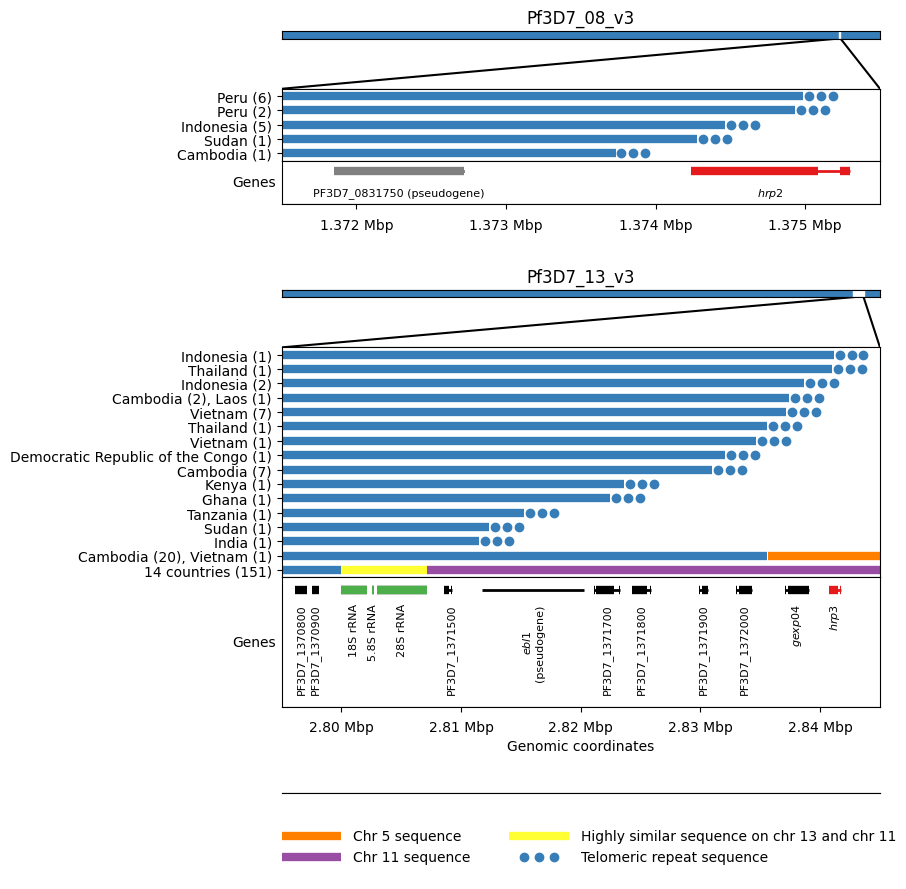

In [16]:
# Full figure

fig, axs = plt.subplots(11, 1, figsize=(9, 9), gridspec_kw={'height_ratios': [1, 7, 10, 6, 12, 1, 7, 32, 18, 12, 12], 'hspace': 0})

### HRP2

# Set the minimum and maximum positions for hrp2
min_pos = 1371500
max_pos = 1375500

## Subplot 1: Title and Chromosome Region

# Set the title
axs[0].set_title('Pf3D7_08_v3')
# Configure the x-axis properties
axs[0].set_xticks([])
axs[0].set_xlabel(None)
# Configure the y-axis properties
axs[0].set_yticks([])
# Set the x-axis limits to match the genomic region of 'Pf3D7_08_v3'
axs[0].set_xlim(int(df_chroms.loc['Pf3D7_08_v3', 'start']), int(df_chroms.loc['Pf3D7_08_v3', 'end']))
# Define the background colour of the subplot
axs[0].set_facecolor(figure_colours['chr_8_13'])
# Add a vertical span between 'min_pos' and 'max_pos' with a white background
axs[0].axvspan(min_pos, max_pos, color='white')

## Subplot 2: Chromosome Boundaries

# Configure x and y axis ticks
axs[1].set_xticks([])
axs[1].set_yticks([])
# Set the x-axis limits to match the genomic region of 'Pf3D7_08_v3'
axs[1].set_xlim(int(df_chroms.loc['Pf3D7_08_v3', 'start']), int(df_chroms.loc['Pf3D7_08_v3', 'end']))
# Define the y-axis limits
axs[1].set_ylim(0, 1)
# Plot horizontal lines marking the start and end positions of 'Pf3D7_08_v3'
axs[1].plot([int(df_chroms.loc['Pf3D7_08_v3', 'start']), min_pos], [0, 1], '-', color='black')
axs[1].plot([int(df_chroms.loc['Pf3D7_08_v3', 'end']), max_pos], [0, 1], '-', color='black')
# Hide the left and right spines for a cleaner appearance
axs[1].spines['left'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# Subplot 3: Deletion Breakpoints by Country

# Create lists for y-axis labels and positions
ylabels = []
yposes = []
# Loop through the sorted df_hrp2
for ypos, row in df_hrp2.sort_values('breakpoint', ascending=False).iterrows():
    yposes.append(ypos)
    # Plot horizontal lines connecting min_pos to each hrp2 deletion breakpoint
    axs[2].plot((min_pos, row['breakpoint']), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_8_13'])
    # Plot circular markers for each breakpoint position
    axs[2].plot(row['breakpoint'] + np.arange(20*2, 101*2, 40*2), [ypos]*3, 'o', color=figure_colours['chr_8_13'])
    # Add country names to the y-labels list
    ylabels.append(f"{row['Countries']}")
# Set y-axis ticks and labels to correspond to country names
axs[2].set_yticks(yposes)
axs[2].set_yticklabels(ylabels)
# Set x-axis limits to cover the specified region between min_pos and max_pos
axs[2].set_xlim(min_pos, max_pos)
# Adjust y-axis limits to include space for data visualization
axs[2].set_ylim(min(yposes) - 0.5, max(yposes) + 0.5)
# Hide x-axis ticks for a cleaner appearance
axs[2].set_xticks([])

## Subplot 4: Genes on the x-axis

# Set the x-axis limits to cover the specified genomic region between min_pos and max_pos
axs[3].set_xlim(min_pos, max_pos)
# Set the y-axis limits to display a region between 0 and 1
axs[3].set_ylim(0, 1)
# Iterate through df_gff to process different gene annotations
for ix, row in df_gff.loc[
    (df_gff['chrom'] == 'Pf3D7_08_v3')
    & (df_gff['start'] <= max_pos)
    & (df_gff['end'] >= min_pos)
    & (df_gff['type'] == 'CDS')
].iterrows():
    # Determine the color based on the genomic position
    if row['start'] >= 1373212 and row['end'] <= 1376988:
        color = figure_colours['hrp_genes']
    else:
        color = figure_colours['other_genes']
    # Plot CDS features with specified line properties and color
    axs[3].plot((row['start'], row['end']), (0.75, 0.75), linewidth=6, solid_capstyle='butt', color=color)

# Iterate through polypeptide
for ix, row in df_gff.loc[
    (df_gff['chrom'] == 'Pf3D7_08_v3')
    & (df_gff['start'] <= max_pos)
    & (df_gff['end'] >= min_pos)
    & (df_gff['type'] == 'polypeptide')
].iterrows():
    if row['start'] >= 1373212 and row['end'] <= 1376988:
        color = figure_colours['hrp_genes']
    else:
        color = figure_colours['other_genes']
    # Plot polypeptide features with different line properties and color
    axs[3].plot((row['start'], row['end']), (0.75, 0.75), linewidth=2, solid_capstyle='butt', color=color)

# Iterate through pseudogene
for ix, row in df_gff.loc[
    (df_gff['chrom'] == 'Pf3D7_08_v3')
    & (df_gff['start'] <= max_pos)
    & (df_gff['end'] >= min_pos)
    & (df_gff['type'] == 'pseudogene')
].iterrows():
    # Plot pseudogene features with specified line properties and color
    axs[3].plot((row['start'], row['end']), (0.75, 0.75), linewidth=6, solid_capstyle='butt', color=figure_colours['pseudogenes'])

# Add text labels for specific genomic regions
axs[3].text((1375299 + 1374236) / 2, 0.25, '${hrp2}$', va='center', ha='center', size=8)
axs[3].text((1371847 + 1372720) / 2, 0.25, 'PF3D7_0831750 (pseudogene)', va='center', ha='center', size=8)

# Set y-axis ticks, labels, and x-axis ticks to maintain an organized representation
axs[3].set_yticks([])
axs[3].set_xticks([])
axs[3].set_ylabel('Genes', rotation=0, ha='right', va='center')

## Subplot 5: Ticks for Genomic Coordinates
# Set the x-axis limits to cover the specified genomic region between 'min_pos' and 'max_pos'
axs[4].set_xlim(min_pos, max_pos)
# Hide the left and right spines to create a cleaner appearance
axs[4].spines['left'].set_visible(False)
axs[4].spines['right'].set_visible(False)
# Configure the x-axis ticks at specific positions
axs[4].set_xticks([1372000, 1373000, 1374000, 1375000])
# Label the x-axis ticks with corresponding values
axs[4].set_xticklabels(["1.372 Mbp", "1.373 Mbp", "1.374 Mbp", "1.375 Mbp"])
# Remove y-axis ticks to maintain a clean look
axs[4].set_yticks([])
# Position x-axis ticks at the top
axs[4].xaxis.tick_top()
# Adjust the direction of x-axis ticks and add padding
axs[4].tick_params(axis="x", direction="in", pad=-20)

### HRP3

# Set the minimum and maximum positions for hrp3
min_pos = 2795000
max_pos = 2845000

## Subplot 6: Title and Chromosome Region

# Set the title
axs[5].set_title('Pf3D7_13_v3')
# Hide the x-axis ticks and labels
axs[5].set_xticks([])
axs[5].set_xlabel(None)
# Hide the y-axis ticks
axs[5].set_yticks([])
# Set the x-axis limits to cover the specified genomic region between the start and end positions of chromosome
axs[5].set_xlim(int(df_chroms.loc['Pf3D7_13_v3', 'start']), int(df_chroms.loc['Pf3D7_13_v3', 'end']))
# Customize the background color of the subplot
axs[5].set_facecolor(figure_colours['chr_8_13'])
# Create a white span on the plot to mark the genomic region of interest
axs[5].axvspan(min_pos, max_pos, color='white')

## Subplot 7: Chromosome Boundaries

# Hide the x-axis ticks and labels
axs[6].set_xticks([])
axs[6].set_yticks([])
# Set the x-axis limits to cover the specified genomic region between the start and end positions of 'Pf3D7_13_v3'
axs[6].set_xlim(int(df_chroms.loc['Pf3D7_13_v3', 'start']), int(df_chroms.loc['Pf3D7_13_v3', 'end']))
# Set the y-axis limits to cover a range from 0 to 1
axs[6].set_ylim(0, 1)
# Create lines to mark the start and end positions of the chromosome region with black color
axs[6].plot([int(df_chroms.loc['Pf3D7_13_v3', 'start']), min_pos], [0, 1], '-', color='black')
axs[6].plot([int(df_chroms.loc['Pf3D7_13_v3', 'end']), max_pos], [0, 1], '-', color='black')
# Hide the left and right spines to create a cleaner appearance
axs[6].spines['left'].set_visible(False)
axs[6].spines['right'].set_visible(False)

## Subplot 8: Deletion Breakpoints by Country

# Initialize lists for labels and positions
ylabels = []
yposes = []
# Iterate through df_hrp3 sorted by breakpoints
for ypos, row in df_hrp3.sort_values('breakpoint', ascending=False).iterrows():
    yposes.append(ypos)

    # Check the deletion type and apply different plotting styles accordingly
    if row['Deletion type'] == 'Telomere healing':
        breakpoint = int(row['breakpoint'])

        # Plot the deletion breakpoint and add circular markers
        axs[7].plot((min_pos, breakpoint), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_8_13'])
        axs[7].plot(int(row['breakpoint']) + np.arange(20*25, 101*25, 40*25), [ypos]*3, 'o', color=figure_colours['chr_8_13'])
        ylabels.append(f"{row['Countries']}")

    if row['Deletion type'] == 'Chromosome 5 recombination':
        breakpoint_start, breakpoint_end = [int(x) for x in row['breakpoint'].split('-')]

        # Plot the breakpoints for Chromosome 5 recombination
        axs[7].plot((min_pos, breakpoint_start), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_8_13'])
        axs[7].plot((breakpoint_end, max_pos), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_5'])
        ylabels.append(f"{row['Countries']}")

    if row['Deletion type'] == 'Chromosome 11 recombination':
        breakpoint_start, breakpoint_end = [int(x) for x in row['breakpoint'].split('-')]

        # Plot the breakpoints for Chromosome 11 recombination
        axs[7].plot((min_pos, breakpoint_start), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_8_13'])
        axs[7].plot((breakpoint_end, max_pos), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_11'])
        axs[7].plot((breakpoint_start, breakpoint_end), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['similar_sequence'])
        ylabels.append(f"14 countries (151)")

# Set the y-axis ticks and labels
axs[7].set_yticks(yposes)
axs[7].set_yticklabels(ylabels)
# Set x-axis limits, y-axis limits, and remove x-axis ticks
axs[7].set_xlim(min_pos, max_pos)
axs[7].set_ylim(min(yposes)-0.5, max(yposes)+0.5)
axs[7].set_xticks([])

## Subplot 9: Genes on the x-axis

bar_pos = 0.9
text_pos = 0.8

# Set the x-axis and y-axis limits
axs[8].set_xlim(min_pos, max_pos)
axs[8].set_ylim(0, 1)
# Iterate through GFF data filtering for relevant features
# Plot CDS features in distinct colors, depending on their location
for ix, row in df_gff.loc[
    ( df_gff['chrom'] == 'Pf3D7_13_v3' )
    & ( df_gff['start'] <= max_pos )
    & ( df_gff['end'] >= min_pos )
    & ( df_gff['type'] == 'CDS' )
].iterrows():
    if row['start'] >= 2840727 and row['end'] <= 2841703:
        color = figure_colours['hrp_genes']
    else:
        color = figure_colours['other_genes']
    axs[8].plot((row['start'], row['end']), (bar_pos, bar_pos), linewidth=6, solid_capstyle='butt', color=color)

# Plot polypeptide features with similar style, with specific colors
for ix, row in df_gff.loc[
    ( df_gff['chrom'] == 'Pf3D7_13_v3' )
    & ( df_gff['start'] <= max_pos )
    & ( df_gff['end'] >= min_pos )
    & ( df_gff['type'] == 'polypeptide' )
].iterrows():
    if row['start'] >= 2840727 and row['end'] <= 2841703:
        color = figure_colours['hrp_genes']
    else:
        color = figure_colours['other_genes']
    axs[8].plot((row['start'], row['end']), (bar_pos, bar_pos), linewidth=2, solid_capstyle='butt', color=color)

# Plot rRNA and pseudogene features
for ix, row in df_gff.loc[
    ( df_gff['chrom'] == 'Pf3D7_13_v3' )
    & ( df_gff['start'] <= max_pos )
    & ( df_gff['end'] >= min_pos )
    & ( df_gff['type'] == 'rRNA' )
].iterrows():
    axs[8].plot((row['start'], row['end']), (bar_pos, bar_pos), linewidth=6, solid_capstyle='butt', color=figure_colours['rrna_genes'])
# Annotate specific gene positions with labels
axs[8].text((2796119 + 2797144) / 2, text_pos, 'PF3D7_1370800', va='top', ha='center', size=8, rotation=90)
axs[8].text((2797507 + 2798103) / 2, text_pos, 'PF3D7_1370900', va='top', ha='center', size=8, rotation=90)
axs[8].text((2800004 + 2802154) / 2, text_pos, '18S rRNA', va='top', ha='center', size=8, rotation=90)
axs[8].text((2802527 + 2802686) / 2, text_pos, '5.8S rRNA', va='top', ha='center', size=8, rotation=90)
axs[8].text((2802945 + 2807159) / 2, text_pos, '28S rRNA', va='top', ha='center', size=8, rotation=90)
axs[8].text((2808200 + 2810256) / 2, text_pos, 'PF3D7_1371500', va='top', ha='center', size=8, rotation=90)
axs[8].text((2811706 + 2820270) / 2, text_pos, '${ebl1}$\n(pseudogene)', va='top', ha='center', size=8, rotation=90)
axs[8].text((2821078 + 2823292) / 2, text_pos, 'PF3D7_1371700', va='top', ha='center', size=8, rotation=90)
axs[8].text((2824302 + 2825852) / 2, text_pos, 'PF3D7_1371800', va='top', ha='center', size=8, rotation=90)
axs[8].text((2829856 + 2830669) / 2, text_pos, 'PF3D7_1371900', va='top', ha='center', size=8, rotation=90)
axs[8].text((2832952 + 2834322) / 2, text_pos, 'PF3D7_1372000', va='top', ha='center', size=8, rotation=90)
axs[8].text((2837053 + 2839058) / 2, text_pos, '${gexp04}$', va='top', ha='center', size=8, rotation=90)
axs[8].text((2840727 + 2841703) / 2, text_pos, '${hrp3}$', va='top', ha='center', size=8, rotation=90)
# Set y-axis ticks, customize x-axis labels, and add x-axis label and y-axis label
axs[8].set_yticks([])
axs[8].set_xticklabels(["", "2.80 Mbp", "2.81 Mbp", "2.82 Mbp", "2.83 Mbp", "2.84 Mbp"])
axs[8].set_xlabel('Genomic coordinates')
axs[8].set_ylabel('Genes', rotation=0, ha='right', va='center')

## Subplot 10: Ticks for Genomic Coordinates

# Set the x-axis limits
axs[9].set_xlim(min_pos, max_pos)
# Hide left and right spines to make the plot clean
axs[9].spines['left'].set_visible(False)
axs[9].spines['right'].set_visible(False)
# Define custom tick positions on the x-axis
axs[9].set_xticks([2800000, 2810000, 2820000, 2830000, 2840000])
# Set custom tick labels corresponding to genomic positions
axs[9].set_xticklabels(["2.80 Mbp", "2.81 Mbp", "2.82 Mbp", "2.83 Mbp", "2.84 Mbp"])
# Hide the y-axis ticks
axs[9].set_yticks([])
# Move the x-axis ticks to the top
axs[9].xaxis.tick_top()
# Adjust the direction and padding of x-axis ticks
axs[9].tick_params(axis="x", direction="in", pad=-20)
# Add a label to the x-axis indicating 'Genomic coordinates' at the center of the x-axis
axs[9].text((min_pos + max_pos) / 2, 0.5, 'Genomic coordinates', ha='center')

## Subplot 11: Legend

# Hide left, right, and bottom spines
axs[10].spines['left'].set_visible(False)
axs[10].spines['right'].set_visible(False)
axs[10].spines['bottom'].set_visible(False)
# Hide both x and y-axis ticks
axs[10].set_xticks([])
axs[10].set_yticks([])
# Create legend elements with color bars and labels
axs[10].plot((0, 0.1), (0.5, 0.5), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_5'])
axs[10].text(0.12, 0.5, 'Chr 5 sequence', va='center')
axs[10].plot((0, 0.1), (0.25, 0.25), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_11'])
axs[10].text(0.12, 0.25, 'Chr 11 sequence', va='center')
axs[10].plot((0.38, 0.48), (0.5, 0.5), linewidth=6, solid_capstyle='butt', color=figure_colours['similar_sequence'])
axs[10].text(0.50, 0.5, 'Highly similar sequence on chr 13 and chr 11', va='center')
axs[10].plot(np.arange(0.405, 0.456, 0.025), [0.25]*3, 'o', color=figure_colours['chr_8_13'])
axs[10].text(0.50, 0.25, 'Telomeric repeat sequence', va='center')
# Set the limits for this subplot
axs[10].set_xlim(0, 1)
axs[10].set_ylim(0, 1)

# Ensure the figure layout is tidy
fig.tight_layout()

**Figure Legend: HRP deletion breakpoints.** We see five different breakpoints resulting in the deletion of hrp2. Four of these are within exon 2 of the gene whereas the fifth is found between hrp2 and the pseudogene PF3D7_0831750. For all five events we see evidence of telomeric healing from reads that contain part Pf3D7_08_v3 sequence and part telomeric repeat sequence (GGGTTCA/GGGTTTA). We see 16 different breakpoints resulting in the deletion of hrp3. For fourteen of these we see evidence of telomeric healing. Note that many of these events result in the deletion of other genes in addition to hrp3. For twenty samples from Cambodia and a single sample from Vietnam we see evidence of a recombination with chromosome 5 which results in a hybrid chromosome comprising mostly chromosome 13 sequence but a small inverted section of an internal portion of chromosome 5 containing the gene mdr1. We also see evidence of a recombination with chromosome 11 which results in a hybrid chromosome comprising mostly chromosome 13 sequence but also a section of the 3’ end of chromosome 11. This is the most common deletion type, being seen in 151 samples from 14 different countries. Because the recombination occurs between highly similar sequences of a set of three orthologous ribosomal RNA genes found on both chromosomes, it is not possible to identify the exact breakpoints.

### Save Figure

In [ ]:
# You will need to authorise Google Colab access to Google Drive
drive.mount('/content/drive')

In [ ]:
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else

fig.savefig('/content/drive/My Drive/HRP_Deletions_Figure.pdf')
fig.savefig('/content/drive/My Drive/HRP_Deletions_Figure.png', dpi=480) # increase the dpi for higher resolution